In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json

from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

# What are the bpps files 
## These are base pairing probability matrix of every possible base pair. 107 X 107 symmetric matrices, where 107 is the number of bases in a RNA sequence

### Ingesting the test dataset which is in json format, then bringing it in pandas dataframe

In [2]:
pd.set_option('display.max_colwidth', None)
json_data = [json.loads(line) for line in open('/kaggle/input/stanford-covid-vaccine/test.json', 'r')]
test_df = pd.DataFrame(json_data)
print(test_df.shape)

(3634, 7)


### Ingesting the training dataset which is in json format, then bringing it in pandas dataframe

In [3]:
pd.set_option('display.max_colwidth', None)
json_data = [json.loads(line) for line in open('/kaggle/input/stanford-covid-vaccine/train.json', 'r')]
train_df = pd.DataFrame(json_data)
print(train_df.shape)

(2400, 19)


# Bringing the bpps data of every sample

## Vectorized method, without creating another dataframe, thereby saving memory

In [4]:
def get_bpps(row):
    file_location = "".join(['/kaggle/input/stanford-covid-vaccine/bpps/',row['id'],'.npy'])
    bpps_data = np.load(file_location)
    bpps_data_list = list(bpps_data)
    bpps_data_list_68 = bpps_data_list[0:68]
    bpps_data_list_68_68 = []
    for j in range(len(bpps_data_list_68)):
        bpps_data_list_68_68.append(bpps_data_list_68[j][0:68])
        
    row['bpps'] = bpps_data_list_68_68
    return row['bpps']

train_df['bpps'] = train_df.apply(get_bpps, axis=1)
test_df['bpps'] = test_df.apply(get_bpps, axis=1)
## Verifications
print(train_df.shape)
print(test_df.shape)

(2400, 20)
(3634, 8)


## Dropping unnecessary columns 

In [5]:
training_columns_to_drop = ['signal_to_noise', 'SN_filter', 'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']
train_df.drop(training_columns_to_drop, axis=1, inplace=True)

test_columns_to_drop = ['seq_length', 'seq_scored']
test_df.drop(test_columns_to_drop, axis=1, inplace=True)

## Breaking down each ID into 68 IDs, one for each RNA base (68 out of the 107 are under modelling scope)
### List based approach, takes way much shorter time than the brute force method

In [6]:
train_colms = ['id_base', 'sequence', 'structure', 'predicted_loop_type', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C', 'bpps']

test_colms = ['id_base', 'sequence', 'structure', 'predicted_loop_type', 'bpps']

def create_rows_per_base(col_name, df):
    col_list = []
    for i in range(df.shape[0]):
        if col_name == 'id_base':
            s = df['id'][i]
            for j in range(68):
                col_list.append("_".join([s, str(j)]))
        else:
            for j in range(68):
                col_list.append(df[col_name][i][j])
            
    return col_list

d_train = {}
for colum in train_colms:
    d_train[colum] = create_rows_per_base(colum, train_df)
    
d_test = {}
for colum in test_colms:
    d_test[colum] = create_rows_per_base(colum, test_df)

seqn_train_df = pd.DataFrame(d_train, columns=train_colms)
seqn_train_df['paired_or_unpaired'] = seqn_train_df['structure'].apply(lambda x: 1 if x == '(' else 1 if x == ')' else 0)
print(seqn_train_df.shape)

seqn_test_df = pd.DataFrame(d_test, columns=test_colms)
seqn_test_df['paired_or_unpaired'] = seqn_test_df['structure'].apply(lambda x: 1 if x == '(' else 1 if x == ')' else 0)
print(seqn_test_df.shape)

(163200, 11)
(247112, 6)


# Creating 68 BPPS columns per base

In [7]:
def add_bpps_per_base(s,j):
    return s[j]

vect_func = np.vectorize(add_bpps_per_base, excluded=['j'])

for jj in range(68):
    seqn_train_df["_".join(['bpps',str(jj)])] = vect_func(seqn_train_df['bpps'], jj)
    
for jj in range(68):
    seqn_test_df["_".join(['bpps',str(jj)])] = vect_func(seqn_test_df['bpps'], jj)
    
print(seqn_train_df.shape)
print(seqn_test_df.shape)

(163200, 79)
(247112, 74)


### Since the provided test dataset is without labels, we will create a test set from the train data to check the accuracy of the model

### Using stratified sampling to split up the training data into train and test sets

array([[<AxesSubplot:title={'center':'reactivity'}>,
        <AxesSubplot:title={'center':'deg_Mg_pH10'}>],
       [<AxesSubplot:title={'center':'deg_pH10'}>,
        <AxesSubplot:title={'center':'deg_Mg_50C'}>],
       [<AxesSubplot:title={'center':'deg_50C'}>, <AxesSubplot:>]],
      dtype=object)

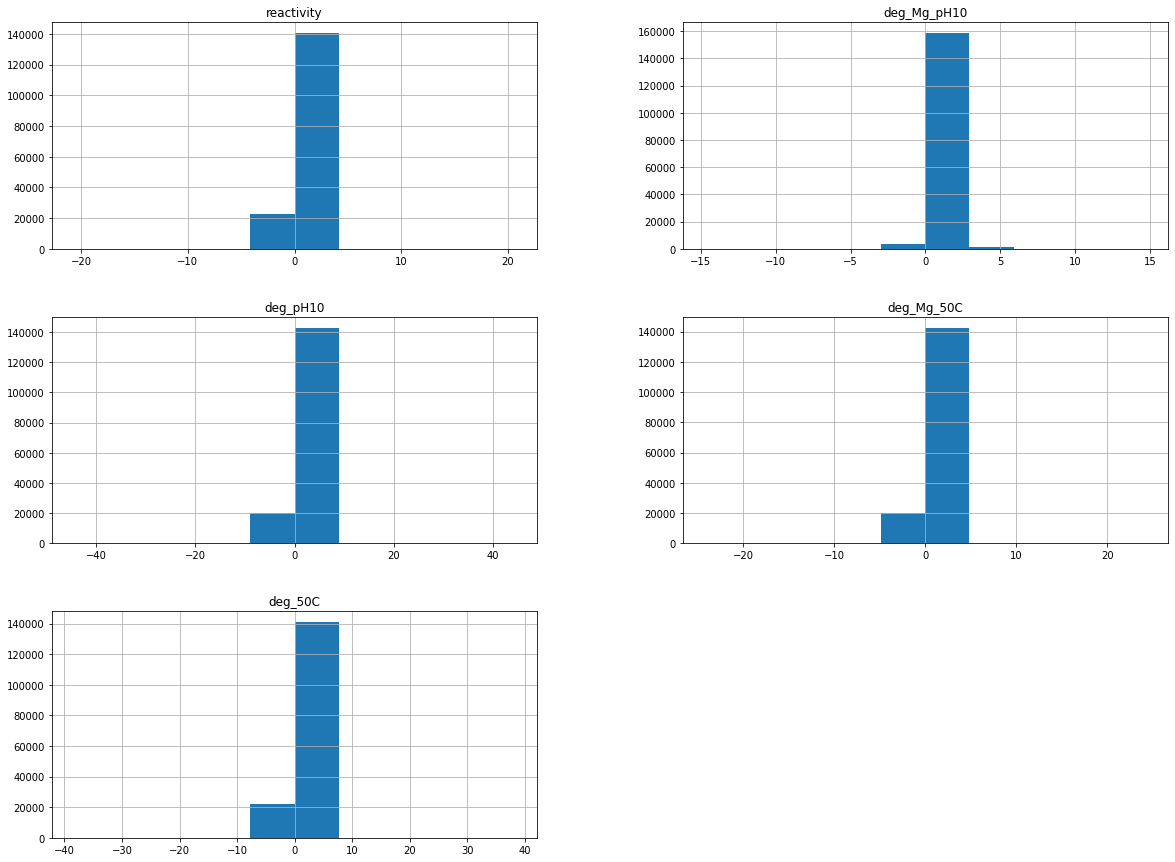

In [8]:
seqn_train_df[['reactivity','deg_Mg_pH10','deg_pH10','deg_Mg_50C','deg_50C']].hist(figsize=(20,15))

In [9]:
seqn_train_df['avg_of_ground_truths'] = (seqn_train_df['reactivity']+seqn_train_df['deg_Mg_pH10']+seqn_train_df['deg_pH10']+seqn_train_df['deg_Mg_50C']+seqn_train_df['deg_50C'])/5

<AxesSubplot:>

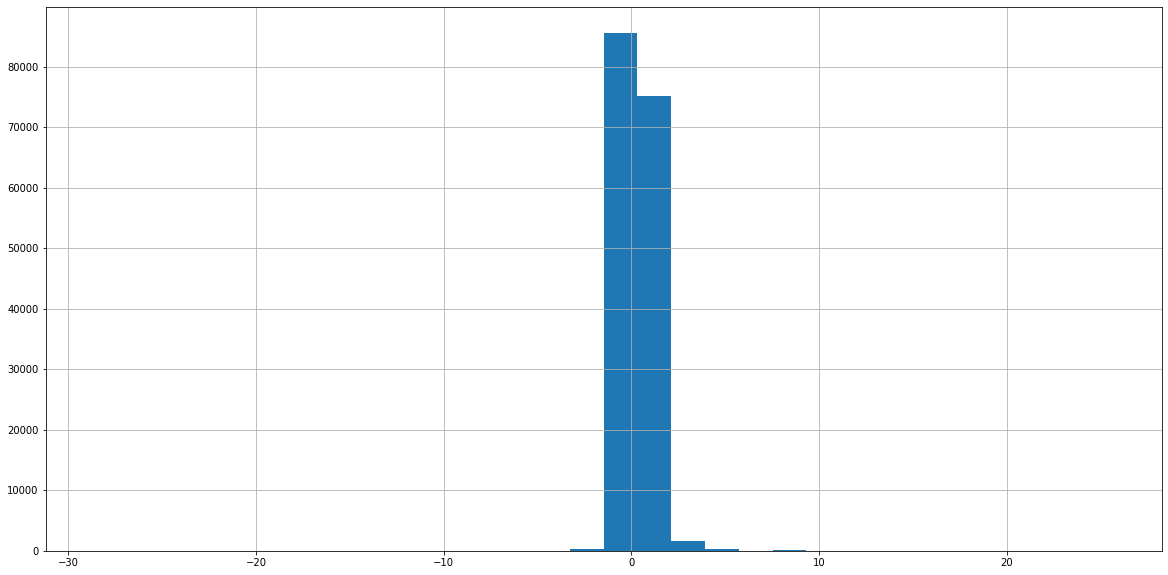

In [10]:
seqn_train_df['avg_of_ground_truths'].hist(bins=30,figsize=(20,10))

In [11]:
seqn_train_df['ground_truth_categories'] = pd.cut(seqn_train_df['avg_of_ground_truths'],
                                                 bins=[-30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0],
                                                 labels=[1,2,3,4,5,6])

<AxesSubplot:>

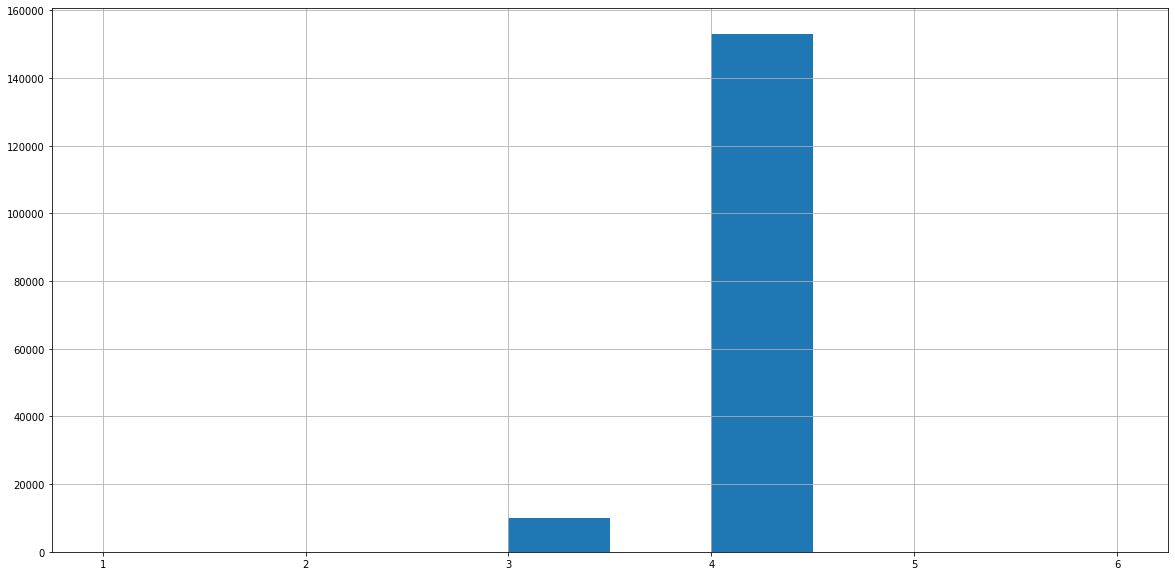

In [12]:
seqn_train_df['ground_truth_categories'].hist(figsize=(20,10))

In [13]:
seqn_train_df['ground_truth_categories'].value_counts()

4    153003
3     10112
1        37
5        29
2        17
6         2
Name: ground_truth_categories, dtype: int64

In [14]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(seqn_train_df, seqn_train_df['ground_truth_categories']):
    strat_train_set = seqn_train_df.loc[train_index]
    strat_test_set = seqn_train_df.loc[test_index]

In [15]:
strat_test_set['ground_truth_categories'].value_counts()/len(strat_test_set)

4    0.937531
3    0.061979
1    0.000214
5    0.000184
2    0.000092
6    0.000000
Name: ground_truth_categories, dtype: float64

In [16]:
strat_train_set['ground_truth_categories'].value_counts()/len(strat_train_set)

4    0.937515
3    0.061956
1    0.000230
5    0.000176
2    0.000107
6    0.000015
Name: ground_truth_categories, dtype: float64

In [17]:
for df in (strat_train_set, strat_test_set):
    df.drop(['avg_of_ground_truths','ground_truth_categories'], axis=1, inplace=True)

## Squaring the numeric columns to avoid the negatives and bring everything onto a similar 2D scale
### Labels are left as-is

In [18]:
seqn_train_df_sqrd = strat_train_set.drop(['structure','bpps'],axis=1)
seqn_test_df_sqrd = strat_test_set.drop(['structure','bpps'],axis=1)
seqn_eval_df_sqrd = seqn_test_df.drop(['structure','bpps'],axis=1)

colms_to_sqr = ['bpps_0', 'bpps_1', 'bpps_2', 'bpps_3', 'bpps_4', 'bpps_5', 'bpps_6', 'bpps_7', 'bpps_8', 'bpps_9', 'bpps_10',
       'bpps_11', 'bpps_12', 'bpps_13', 'bpps_14', 'bpps_15', 'bpps_16','bpps_17', 'bpps_18', 'bpps_19', 'bpps_20', 'bpps_21', 'bpps_22',
       'bpps_23', 'bpps_24', 'bpps_25', 'bpps_26', 'bpps_27', 'bpps_28','bpps_29', 'bpps_30', 'bpps_31', 'bpps_32', 'bpps_33', 'bpps_34',
       'bpps_35', 'bpps_36', 'bpps_37', 'bpps_38', 'bpps_39', 'bpps_40','bpps_41', 'bpps_42', 'bpps_43', 'bpps_44', 'bpps_45', 'bpps_46',
       'bpps_47', 'bpps_48', 'bpps_49', 'bpps_50', 'bpps_51', 'bpps_52','bpps_53', 'bpps_54', 'bpps_55', 'bpps_56', 'bpps_57', 'bpps_58',
       'bpps_59', 'bpps_60', 'bpps_61', 'bpps_62', 'bpps_63', 'bpps_64','bpps_65', 'bpps_66', 'bpps_67']

for i in range(len(colms_to_sqr)):
    col_name = colms_to_sqr[i]
    sqrd_col_name = "_".join([col_name,'sqrd'])
    seqn_train_df_sqrd[sqrd_col_name] = np.square(seqn_train_df_sqrd[col_name])
    seqn_test_df_sqrd[sqrd_col_name] = np.square(seqn_test_df_sqrd[col_name])
    seqn_eval_df_sqrd[sqrd_col_name] = np.square(seqn_eval_df_sqrd[col_name])  

seqn_train_df_sqrd.drop(colms_to_sqr, axis=1, inplace=True)
print(seqn_train_df_sqrd.shape)

seqn_test_df_sqrd.drop(colms_to_sqr, axis=1, inplace=True)
print(seqn_test_df_sqrd.shape)

seqn_eval_df_sqrd.drop(colms_to_sqr, axis=1, inplace=True)
print(seqn_eval_df_sqrd.shape)

(130560, 77)
(32640, 77)
(247112, 72)


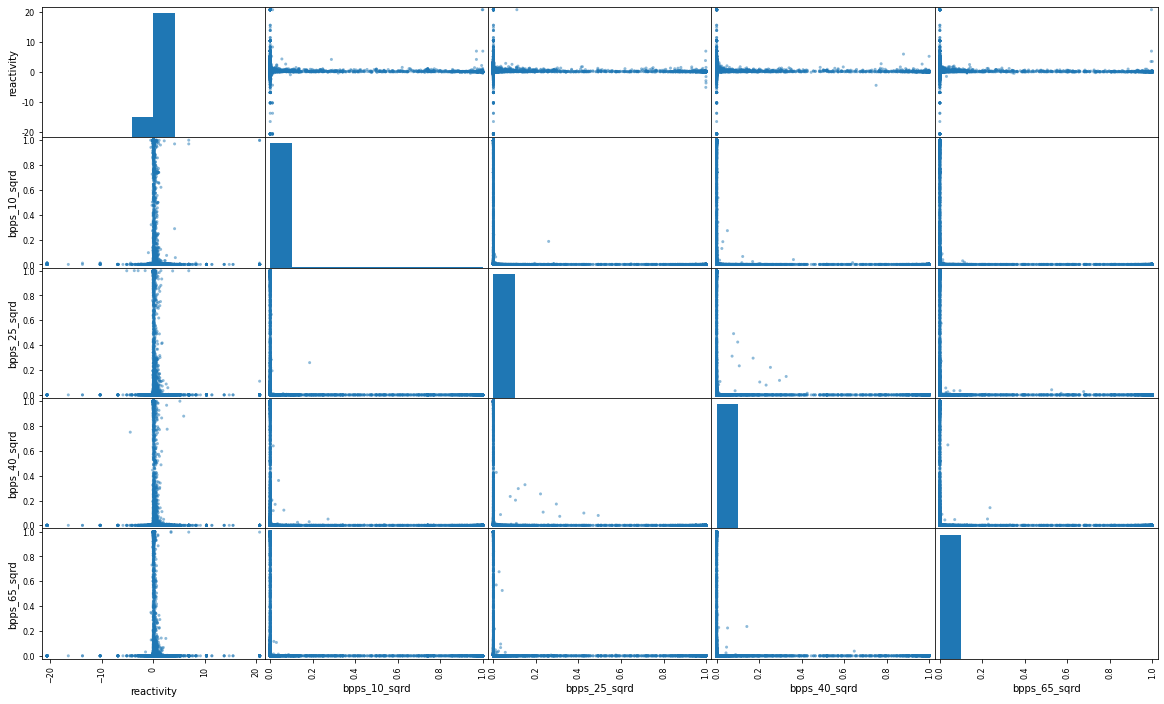

In [19]:
attributes = ['reactivity', 'bpps_10_sqrd', 'bpps_25_sqrd', 'bpps_40_sqrd', 'bpps_65_sqrd']

scatter_plot_arr = scatter_matrix(seqn_train_df_sqrd[attributes], figsize=(20,12))

<AxesSubplot:xlabel='bpps_51_sqrd', ylabel='deg_pH10'>

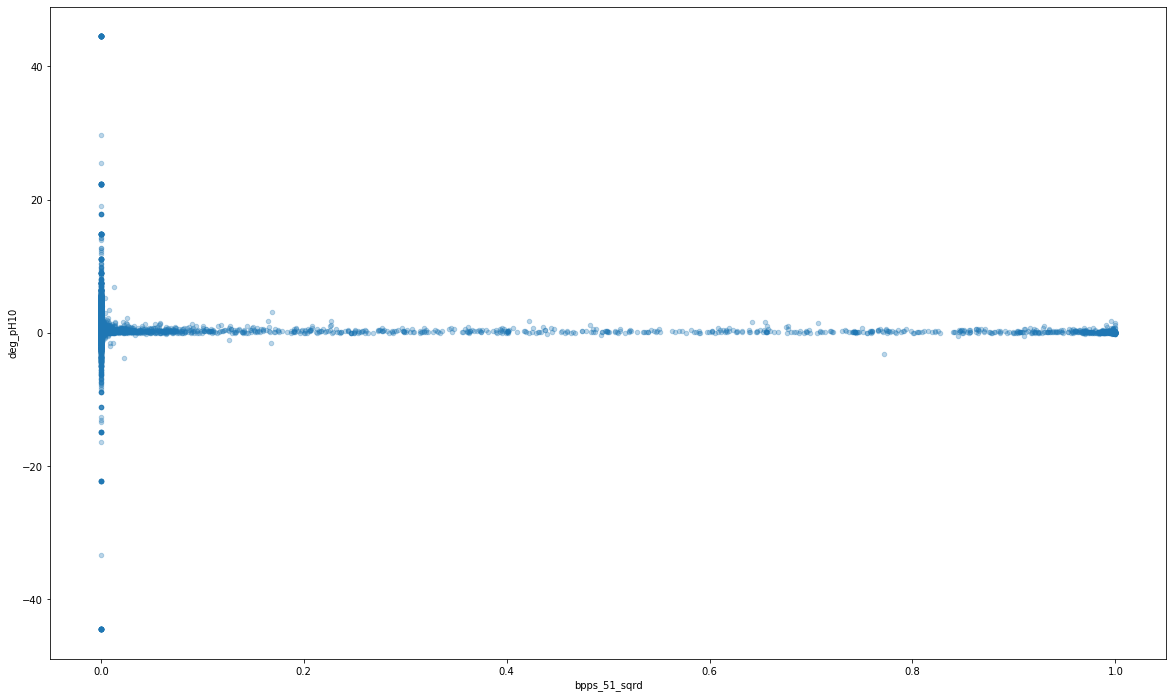

In [20]:
seqn_train_df_sqrd.plot(kind="scatter", x="bpps_51_sqrd", y="deg_pH10", alpha=0.3, figsize=(20,12))

### Observing a polynomial relationship (y=1/x) which has quite a few outliers, applying standardization (subtract by mean then divide by standard deviation) to reduce those.
### Using standardization to reduce the effect of outliers in feature scaling

In [21]:
colms_for_std = [
       'bpps_0_sqrd', 'bpps_1_sqrd',
       'bpps_2_sqrd', 'bpps_3_sqrd', 'bpps_4_sqrd', 'bpps_5_sqrd',
       'bpps_6_sqrd', 'bpps_7_sqrd', 'bpps_8_sqrd', 'bpps_9_sqrd',
       'bpps_10_sqrd', 'bpps_11_sqrd', 'bpps_12_sqrd', 'bpps_13_sqrd',
       'bpps_14_sqrd', 'bpps_15_sqrd', 'bpps_16_sqrd', 'bpps_17_sqrd',
       'bpps_18_sqrd', 'bpps_19_sqrd', 'bpps_20_sqrd', 'bpps_21_sqrd',
       'bpps_22_sqrd', 'bpps_23_sqrd', 'bpps_24_sqrd', 'bpps_25_sqrd',
       'bpps_26_sqrd', 'bpps_27_sqrd', 'bpps_28_sqrd', 'bpps_29_sqrd',
       'bpps_30_sqrd', 'bpps_31_sqrd', 'bpps_32_sqrd', 'bpps_33_sqrd',
       'bpps_34_sqrd', 'bpps_35_sqrd', 'bpps_36_sqrd', 'bpps_37_sqrd',
       'bpps_38_sqrd', 'bpps_39_sqrd', 'bpps_40_sqrd', 'bpps_41_sqrd',
       'bpps_42_sqrd', 'bpps_43_sqrd', 'bpps_44_sqrd', 'bpps_45_sqrd',
       'bpps_46_sqrd', 'bpps_47_sqrd', 'bpps_48_sqrd', 'bpps_49_sqrd',
       'bpps_50_sqrd', 'bpps_51_sqrd', 'bpps_52_sqrd', 'bpps_53_sqrd',
       'bpps_54_sqrd', 'bpps_55_sqrd', 'bpps_56_sqrd', 'bpps_57_sqrd',
       'bpps_58_sqrd', 'bpps_59_sqrd', 'bpps_60_sqrd', 'bpps_61_sqrd',
       'bpps_62_sqrd', 'bpps_63_sqrd', 'bpps_64_sqrd', 'bpps_65_sqrd',
       'bpps_66_sqrd', 'bpps_67_sqrd'
]

for i in range(len(colms_for_std)):
    col_name = colms_for_std[i]
    col_name_std = "_".join([col_name, 'std'])
    seqn_train_df_sqrd[col_name_std] = (seqn_train_df_sqrd[col_name] - seqn_train_df_sqrd[col_name].mean())/seqn_train_df_sqrd[col_name].std()
    seqn_test_df_sqrd[col_name_std] = (seqn_test_df_sqrd[col_name] - seqn_test_df_sqrd[col_name].mean())/seqn_test_df_sqrd[col_name].std()
    seqn_eval_df_sqrd[col_name_std] = (seqn_eval_df_sqrd[col_name] - seqn_eval_df_sqrd[col_name].mean())/seqn_eval_df_sqrd[col_name].std()

seqn_train_df_sqrd.drop(colms_for_std, axis=1, inplace=True)
print(seqn_train_df_sqrd.shape)

seqn_test_df_sqrd.drop(colms_for_std, axis=1, inplace=True)
print(seqn_test_df_sqrd.shape)

seqn_eval_df_sqrd.drop(colms_for_std, axis=1, inplace=True)
print(seqn_eval_df_sqrd.shape)

(130560, 77)
(32640, 77)
(247112, 72)


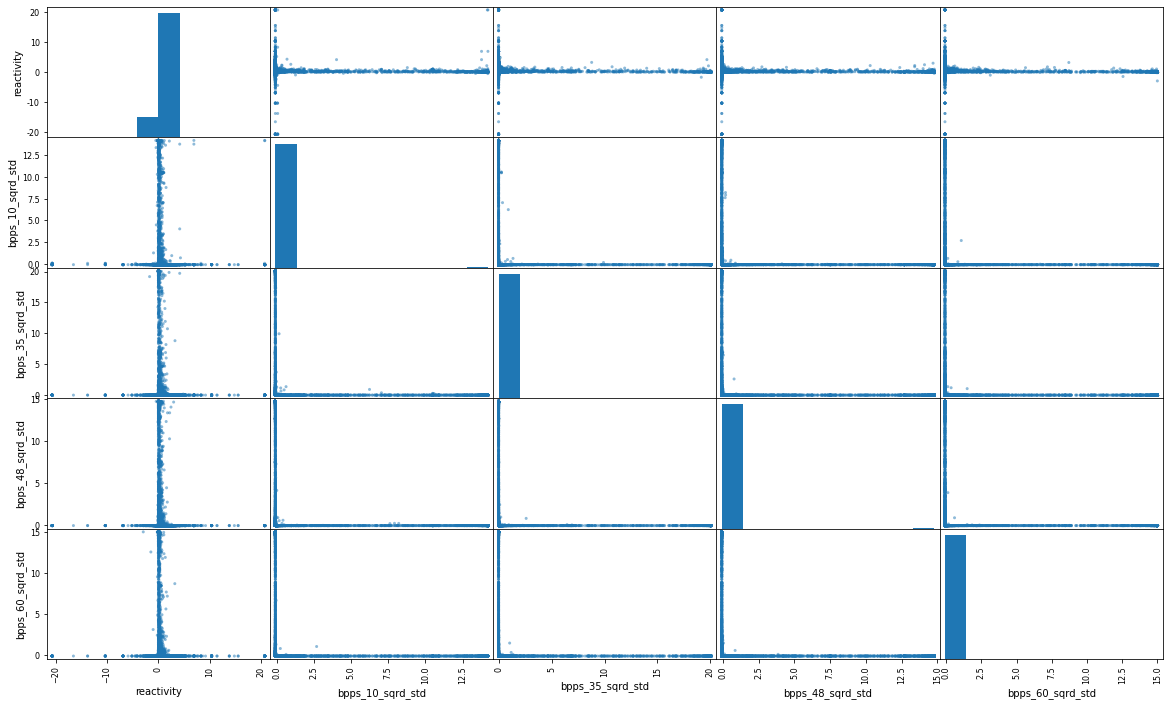

In [22]:
attributes = ['reactivity', 'bpps_10_sqrd_std', 'bpps_35_sqrd_std', 'bpps_48_sqrd_std', 'bpps_60_sqrd_std']

scatter_plot_arr = scatter_matrix(seqn_train_df_sqrd[attributes], figsize=(20,12))

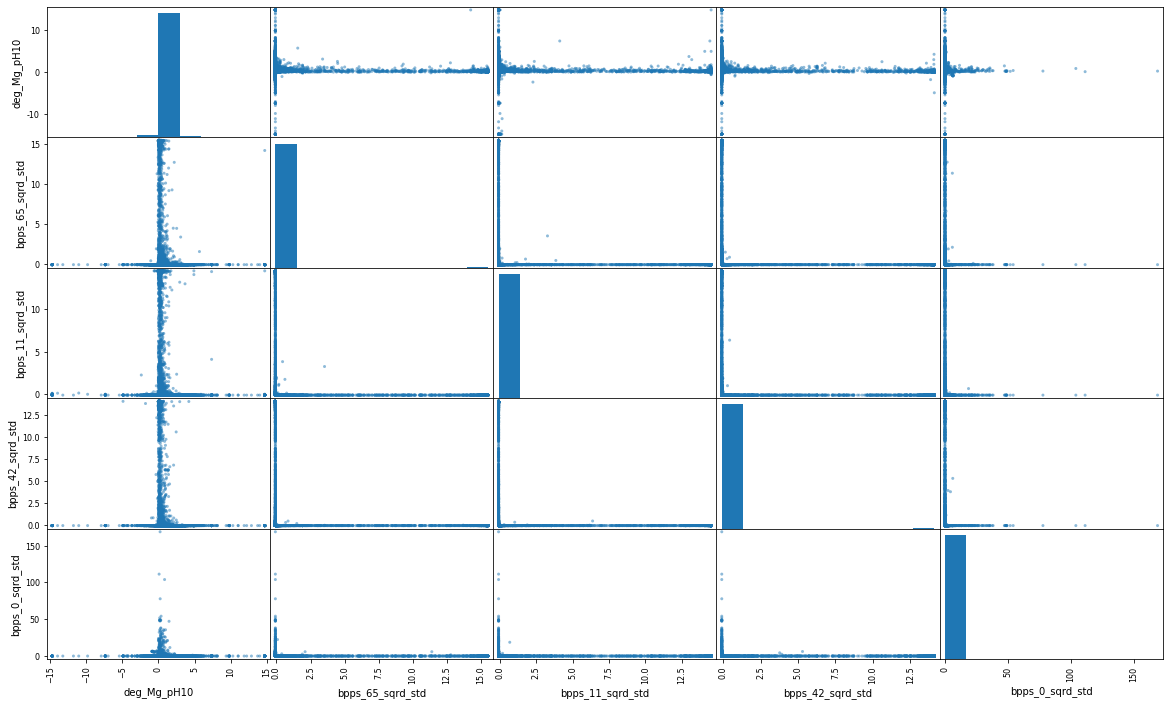

In [23]:
attributes = ['deg_Mg_pH10', 'bpps_65_sqrd_std', 'bpps_11_sqrd_std', 'bpps_42_sqrd_std', 'bpps_0_sqrd_std']

scatter_plot_arr = scatter_matrix(seqn_train_df_sqrd[attributes], figsize=(20,12))

<AxesSubplot:xlabel='bpps_65_sqrd_std', ylabel='deg_Mg_pH10'>

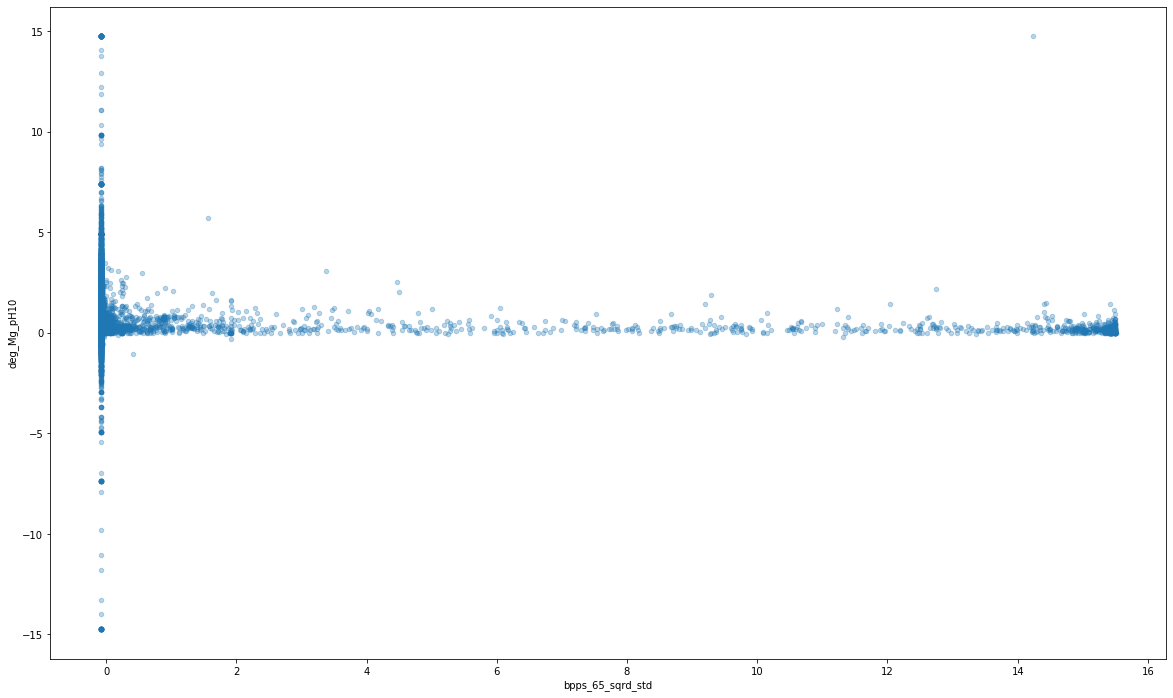

In [24]:
seqn_train_df_sqrd.plot(kind="scatter", x="bpps_65_sqrd_std", y="deg_Mg_pH10", alpha=0.3, figsize=(20,12))

In [25]:
corr_matrix = seqn_train_df_sqrd.corr()
#corr_matrix[['reactivity_sqrd_std', 'deg_Mg_pH10_sqrd_std', 'deg_pH10_sqrd_std', 'deg_Mg_50C_sqrd_std', 'deg_50C_sqrd_std']]
corr_matrix

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,paired_or_unpaired,bpps_0_sqrd_std,bpps_1_sqrd_std,bpps_2_sqrd_std,bpps_3_sqrd_std,...,bpps_58_sqrd_std,bpps_59_sqrd_std,bpps_60_sqrd_std,bpps_61_sqrd_std,bpps_62_sqrd_std,bpps_63_sqrd_std,bpps_64_sqrd_std,bpps_65_sqrd_std,bpps_66_sqrd_std,bpps_67_sqrd_std
reactivity,1.000000,0.468421,0.423882,0.497447,0.452006,-0.265098,-0.006773,-0.011058,-0.004187,-0.000936,...,-0.027925,-0.028712,-0.031099,-0.029170,-0.032279,-0.033296,-0.031035,-0.024929,-0.024568,-0.020635
deg_Mg_pH10,0.468421,1.000000,0.440746,0.558036,0.416830,-0.185540,-0.004562,-0.007421,-0.004607,-0.000675,...,-0.024910,-0.021098,-0.026928,-0.022806,-0.024353,-0.023310,-0.024386,-0.021070,-0.013263,-0.008900
deg_pH10,0.423882,0.440746,1.000000,0.503934,0.469819,-0.132159,0.000686,-0.002969,0.001316,0.004400,...,-0.016296,-0.014458,-0.016867,-0.013956,-0.014314,-0.010899,-0.010065,-0.008628,-0.004387,-0.004606
deg_Mg_50C,0.497447,0.558036,0.503934,1.000000,0.492834,-0.187452,-0.002562,-0.005395,-0.002189,0.000122,...,-0.020816,-0.020511,-0.025064,-0.022975,-0.023162,-0.021833,-0.019103,-0.020236,-0.010736,-0.010491
deg_50C,0.452006,0.416830,0.469819,0.492834,1.000000,-0.133403,0.001408,-0.006175,-0.003456,-0.001761,...,-0.017700,-0.015278,-0.018507,-0.016603,-0.017154,-0.015037,-0.014212,-0.012406,-0.006550,-0.006827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bpps_63_sqrd_std,-0.033296,-0.023310,-0.010899,-0.021833,-0.015037,0.083095,-0.001666,-0.002057,-0.001847,-0.002052,...,-0.006472,-0.006436,-0.006340,-0.006260,-0.006883,1.000000,-0.006223,-0.006113,-0.005761,-0.004147
bpps_64_sqrd_std,-0.031035,-0.024386,-0.010065,-0.019103,-0.014212,0.078720,-0.002250,-0.001703,-0.001294,-0.002031,...,-0.006323,-0.006145,-0.006291,-0.006326,-0.006226,-0.006223,1.000000,-0.006084,-0.005165,-0.004363
bpps_65_sqrd_std,-0.024929,-0.021070,-0.008628,-0.020236,-0.012406,0.075048,-0.001473,-0.000942,-0.001708,-0.001939,...,-0.006145,-0.005962,-0.005991,-0.006264,-0.006310,-0.006113,-0.006084,1.000000,-0.005165,-0.003753
bpps_66_sqrd_std,-0.024568,-0.013263,-0.004387,-0.010736,-0.006550,0.066037,-0.000367,-0.001844,-0.001213,-0.001423,...,-0.005455,-0.005375,-0.005379,-0.005588,-0.005459,-0.005761,-0.005165,-0.005165,1.000000,-0.003768


### From above its quite clear that none of the default features available with the data frame have very high linear correlations. However the charts shows non-linear correlations, hence progressing further

### inversing the bpps column entries

In [26]:
colms_for_std = []

for i in range(68):
    colms_for_std.append("_".join(['bpps',str(i),'sqrd_std']))

for i in range(len(colms_for_std)):
    col_name = colms_for_std[i]
    col_name_std = "_".join([col_name, 'inv'])
    seqn_train_df_sqrd[col_name_std] = 1/seqn_train_df_sqrd[col_name]
    seqn_test_df_sqrd[col_name_std] = 1/seqn_test_df_sqrd[col_name]
    seqn_eval_df_sqrd[col_name_std] = 1/seqn_eval_df_sqrd[col_name]

seqn_train_df_sqrd.drop(colms_for_std, axis=1, inplace=True)
print(seqn_train_df_sqrd.shape)

seqn_test_df_sqrd.drop(colms_for_std, axis=1, inplace=True)
print(seqn_test_df_sqrd.shape)

seqn_eval_df_sqrd.drop(colms_for_std, axis=1, inplace=True)
print(seqn_eval_df_sqrd.shape)

(130560, 77)
(32640, 77)
(247112, 72)


In [27]:
corr_matrix = seqn_train_df_sqrd.corr()
corr_matrix

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,paired_or_unpaired,bpps_0_sqrd_std_inv,bpps_1_sqrd_std_inv,bpps_2_sqrd_std_inv,bpps_3_sqrd_std_inv,...,bpps_58_sqrd_std_inv,bpps_59_sqrd_std_inv,bpps_60_sqrd_std_inv,bpps_61_sqrd_std_inv,bpps_62_sqrd_std_inv,bpps_63_sqrd_std_inv,bpps_64_sqrd_std_inv,bpps_65_sqrd_std_inv,bpps_66_sqrd_std_inv,bpps_67_sqrd_std_inv
reactivity,1.000000,0.468421,0.423882,0.497447,0.452006,-0.265098,-0.002173,-0.000377,5.030437e-04,-0.002055,...,-0.002173,-0.001731,-0.001870,-0.001243,-0.003681,-0.003892,0.000148,-0.000901,-0.000155,-0.000045
deg_Mg_pH10,0.468421,1.000000,0.440746,0.558036,0.416830,-0.185540,-0.001553,0.002170,4.652024e-04,-0.004283,...,-0.000279,0.000273,-0.002915,0.000114,-0.003657,-0.002458,0.000655,-0.000976,0.002175,0.000167
deg_pH10,0.423882,0.440746,1.000000,0.503934,0.469819,-0.132159,-0.000301,0.002191,-1.454322e-04,-0.000684,...,-0.000552,0.000976,-0.001120,0.000243,-0.002055,-0.001388,0.000420,-0.001418,0.000818,-0.000391
deg_Mg_50C,0.497447,0.558036,0.503934,1.000000,0.492834,-0.187452,-0.001244,0.002631,4.102105e-04,-0.002509,...,-0.000633,-0.000153,-0.002275,0.000208,-0.002537,0.001421,0.000268,-0.001254,0.002226,-0.000740
deg_50C,0.452006,0.416830,0.469819,0.492834,1.000000,-0.133403,-0.000882,0.002676,-5.475177e-05,-0.000503,...,-0.000070,0.000626,-0.001868,0.000386,-0.001805,0.000477,0.000385,-0.001130,-0.000561,-0.000050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bpps_63_sqrd_std_inv,-0.003892,-0.002458,-0.001388,0.001421,0.000477,0.015937,0.000098,-0.000064,7.957314e-05,-0.000154,...,0.000027,-0.001090,-0.000166,0.000698,0.000284,1.000000,0.000001,-0.000081,0.000621,0.004594
bpps_64_sqrd_std_inv,0.000148,0.000655,0.000420,0.000268,0.000385,0.003641,-0.000018,-0.000001,6.675497e-07,0.000200,...,-0.000019,0.000066,0.000105,-0.000435,-0.000161,0.000001,1.000000,-0.000364,0.000123,0.000091
bpps_65_sqrd_std_inv,-0.000901,-0.000976,-0.001418,-0.001254,-0.001130,0.001389,0.000023,0.000007,-6.590873e-06,0.000017,...,-0.000021,-0.000010,0.000058,-0.000021,0.000286,-0.000081,-0.000364,1.000000,0.000216,-0.000303
bpps_66_sqrd_std_inv,-0.000155,0.002175,0.000818,0.002226,-0.000561,0.007211,0.000195,0.000014,2.803189e-05,-0.001476,...,0.000135,0.000253,-0.001059,-0.000100,-0.001745,0.000621,0.000123,0.000216,1.000000,0.002059


### separating out the features and labels and then will try out some combinations to see if we can improve the correlations

In [28]:
seqn_train_df_sqrd_labels = seqn_train_df_sqrd[['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
seqn_test_df_sqrd_labels = seqn_test_df_sqrd[['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
feature_colums = ['sequence', 'predicted_loop_type', 'paired_or_unpaired']
for i in range(68):
    feature_colums.append("_".join(['bpps',str(i),'sqrd_std_inv']))

seqn_train_df_sqrd_features = seqn_train_df_sqrd[feature_colums]
seqn_test_df_sqrd_features = seqn_test_df_sqrd[feature_colums]
seqn_eval_df_sqrd_features = seqn_eval_df_sqrd[feature_colums]

### First lets try building a model using available features as-is

In [29]:
polynomial_pipeline = Pipeline([('poly',PolynomialFeatures(degree=1, include_bias=False))])

categorical_attributes = ['sequence','predicted_loop_type']
numeric_atributes = ['paired_or_unpaired']

for i in range(68):
    numeric_atributes.append("_".join(['bpps',str(i),'sqrd_std_inv']))

modelling_pipeline = ColumnTransformer([
    ("categorical_attributes", OneHotEncoder(), categorical_attributes),
    ("numeric_atributes", polynomial_pipeline, numeric_atributes)
])

seqn_train_df_prepared = modelling_pipeline.fit_transform(seqn_train_df_sqrd_features)

In [30]:
seqn_test_df_prepared = modelling_pipeline.fit_transform(seqn_test_df_sqrd_features)
seqn_eval_df_prepared = modelling_pipeline.fit_transform(seqn_eval_df_sqrd_features)

In [31]:
print(seqn_train_df_prepared.shape)
print(seqn_train_df_sqrd_features.shape)
print(seqn_test_df_sqrd_features.shape)
print(seqn_eval_df_sqrd_features.shape)

(130560, 80)
(130560, 71)
(32640, 71)
(247112, 71)


In [32]:
from sklearn.linear_model import LinearRegression

poly_reg_model = LinearRegression()
poly_reg_model.fit(seqn_train_df_prepared, seqn_train_df_sqrd_labels)

LinearRegression()

### Testing the RMSE
#### RMSE <= 0.75 : Very good accuracy
#### 0.75 < RMSE <= 1.0 : Good accuracy

### Lets investigate the RMSE

In [33]:
seqn_train_df_predictions = poly_reg_model.predict(seqn_train_df_prepared)
mse = mean_squared_error(seqn_train_df_sqrd_labels, seqn_train_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

0.9589117983811916


### on test data

In [34]:
seqn_test_df_predictions = poly_reg_model.predict(seqn_test_df_prepared)
mse = mean_squared_error(seqn_test_df_sqrd_labels, seqn_test_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

0.908978810462746


In [35]:
seqn_eval_df_predictions = pd.DataFrame(poly_reg_model.predict(seqn_eval_df_prepared),columns=['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C'])

In [36]:
seqn_eval_df_predictions['id_seqpos'] = seqn_eval_df_sqrd['id_base']

In [37]:
seqn_eval_df_predictions.head(10)

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.590867,0.708907,1.012922,0.691743,0.706352,id_00073f8be_0
1,0.590872,0.708918,1.012926,0.691753,0.706350,id_00073f8be_1
2,0.580561,0.545989,0.719594,0.635667,0.646580,id_00073f8be_2
3,0.580561,0.545990,0.719594,0.635667,0.646580,id_00073f8be_3
4,0.580562,0.545990,0.719592,0.635668,0.646580,id_00073f8be_4
5,0.580662,0.545991,0.719536,0.635634,0.646515,id_00073f8be_5
6,0.253715,0.413818,0.426746,0.301995,0.325935,id_00073f8be_6
7,0.188355,0.317690,0.237717,0.229570,0.286701,id_00073f8be_7
8,0.241712,0.247662,0.130902,0.241720,0.266027,id_00073f8be_8
9,0.056408,0.252839,0.223548,0.186779,0.216804,id_00073f8be_9


In [38]:
submission_df = seqn_eval_df_predictions[['id_seqpos','reactivity','deg_Mg_pH10','deg_pH10','deg_Mg_50C','deg_50C']]
submission_df.head(10)

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.590867,0.708907,1.012922,0.691743,0.706352
1,id_00073f8be_1,0.590872,0.708918,1.012926,0.691753,0.706350
2,id_00073f8be_2,0.580561,0.545989,0.719594,0.635667,0.646580
3,id_00073f8be_3,0.580561,0.545990,0.719594,0.635667,0.646580
4,id_00073f8be_4,0.580562,0.545990,0.719592,0.635668,0.646580
5,id_00073f8be_5,0.580662,0.545991,0.719536,0.635634,0.646515
6,id_00073f8be_6,0.253715,0.413818,0.426746,0.301995,0.325935
7,id_00073f8be_7,0.188355,0.317690,0.237717,0.229570,0.286701
8,id_00073f8be_8,0.241712,0.247662,0.130902,0.241720,0.266027
9,id_00073f8be_9,0.056408,0.252839,0.223548,0.186779,0.216804


### The overall RMSE looks okay, not too good, neither too bad, as expected, since there was poor correlation

In [39]:
def calculate_rmse(actuals, label_name, predictions, prediction_loc):
    mse = mean_squared_error(actuals[label_name], predictions[:,prediction_loc])
    rmse = np.sqrt(mse)
    return rmse

In [40]:
print(calculate_rmse(seqn_train_df_sqrd_labels, 'reactivity', seqn_train_df_predictions, prediction_loc=0))

0.6900777684230793


In [41]:
def calculate_mcrmse():
    labels = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
    rmse = 0
    for i in range(len(labels)):
        rmse = rmse + calculate_rmse(seqn_train_df_sqrd_labels, labels[i], seqn_train_df_predictions, prediction_loc=i)
    mcrmse = rmse/len(labels)
    return mcrmse

# MCRMSE

In [42]:
print(calculate_mcrmse())

0.9291558613552173


### Performing cross-validation to see if the performance is consistent

In [43]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(poly_reg_model, seqn_train_df_prepared, seqn_train_df_sqrd_labels, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [44]:
def display_cv_scores(scores):
    print("Scores : ", scores)
    print("Mean : ", scores.mean())
    print("Standard Deviation : ", scores.std())

In [45]:
display_cv_scores(rmse_scores)

Scores :  [1.03520632 0.98442679 1.03308069 0.99301081 0.93330863 0.91431197
 0.86361272 0.87562424 0.92575161 1.08762959]
Mean :  0.9645963375735416
Standard Deviation :  0.07010261153088622


## Trying a decision tree regression model

In [46]:
from sklearn.tree import DecisionTreeRegressor

tree_reg_model = DecisionTreeRegressor()
tree_reg_model.fit(seqn_train_df_prepared, seqn_train_df_sqrd_labels)

DecisionTreeRegressor()

In [47]:
seqn_train_df_predictions = tree_reg_model.predict(seqn_train_df_prepared)
mse = mean_squared_error(seqn_train_df_sqrd_labels, seqn_train_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

0.5247632339543352


In [48]:
seqn_test_df_predictions = tree_reg_model.predict(seqn_test_df_prepared)
mse = mean_squared_error(seqn_test_df_sqrd_labels, seqn_test_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

1.139748939636142


In [49]:
print(calculate_mcrmse())

0.5043958657654694
